In [26]:
pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.2/155.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 8.4 MB/s eta 0:00:00m eta 0:00:010:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 13.2 MB/s eta 0:00:000:00:01m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.9 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 6.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


     mois                      region  nombre_total_passages  \
0     1.0        Auvergne-Rhône-Alpes                 184120   
1     1.0     Bourgogne-Franche-Comté                  65855   
2     1.0                    Bretagne                  65360   
3     1.0         Centre-Val de Loire                  54071   
4     1.0                       Corse                   7693   
..    ...                         ...                    ...   
187  12.0                   Normandie                  17337   
188  12.0          Nouvelle-Aquitaine                  22125   
189  12.0                   Occitanie                  27933   
190  12.0            Pays de la Loire                  10683   
191  12.0  Provence-Alpes-Côte d'Azur                  27100   

     nombre_passage_corona             pourcentage  
0                      729  0.39593743210949380839  
1                      352  0.53450763040012147901  
2                      263  0.40238678090575275398  
3                  

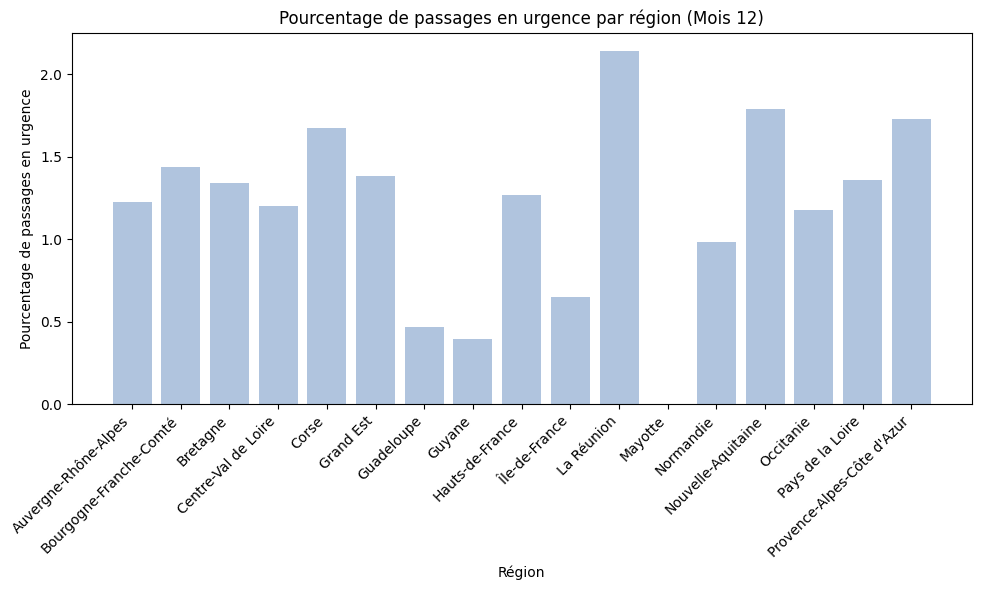

In [61]:
import psycopg2
import numpy as np 
import psycopg2.extras as extras 
import pandas as pd 
import matplotlib.pyplot as plt


"""Quel est le pourcentage de passages aux urgences pour suspicion de covid-19 par rapport au
nombre de passages total, par mois et par région ?"""


def connexion():
    return psycopg2.connect(
   database="postgres",
   user="airflow",
   password="airflow",
   host="172.17.0.1",
   port= '5435')




def lecture(conn):
    """ Lecture des tables """
    command = """
        SELECT
            EXTRACT(MONTH FROM um.date_de_passage) AS mois,
            d.region,
            SUM(nbre_pass_tot) AS nombre_total_passages,
            SUM(nbre_pass_corona) AS nombre_passage_corona,
            (SUM(nbre_pass_corona)*100.0)/SUM(nbre_pass_tot) AS pourcentage
            
        FROM
            urgence_mesures um
        JOIN
            departement d ON um.dep = d.id_dep
        WHERE um.code_age = 0.0
        GROUP BY
            mois,d.region;
        """
    try:
        cur = conn.cursor()
        cur.execute(command)
        
        # Fetch data
        data = cur.fetchall()
        columns = [desc[0] for desc in cur.description]
        df = pd.DataFrame(data, columns=columns)
        
        # Display the DataFrame
        print(df)

    except (Exception, psycopg2.DatabaseError) as error:
        print("Error")
        print(error)
    finally:
        if cur is not None:
            cur.close()
        if conn is not None:
            conn.close()
        return df

# Call the function
connexion_instance = connexion()
df = lecture(connexion_instance)

# Filtrer les données pour un mois spécifique (par exemple, le mois 12)
df_mois_12 = df[df['mois'] == 12.0]

# Créer un graphique à barres
plt.figure(figsize=(10, 6))
plt.bar(df_mois_12['region'], df_mois_12['pourcentage'], color='lightsteelblue')
plt.xlabel('Région')
plt.ylabel('Pourcentage de passages en urgence')
plt.title('Pourcentage de passages en urgence par région (Mois 12)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Afficher le graphique
plt.show()

    annee  code_age  nombre_total_passages  nombre_passage_corona  \
0  2022.0         0                 300420                   3654   
1  2022.0         1                  41445                    252   
2  2022.0         2                  24991                     21   
3  2022.0         3                  96105                    420   
4  2022.0         4                  57217                    502   
5  2022.0         5                  29083                    576   
6  2022.0         6                  51562                   1883   

              pourcentage  
0      1.2162971839424805  
1  0.60803474484256243214  
2  0.08403025089032051539  
3  0.43702200717964726081  
4  0.87736162329377632522  
5      1.9805384588935117  
6      3.6519142003801249  


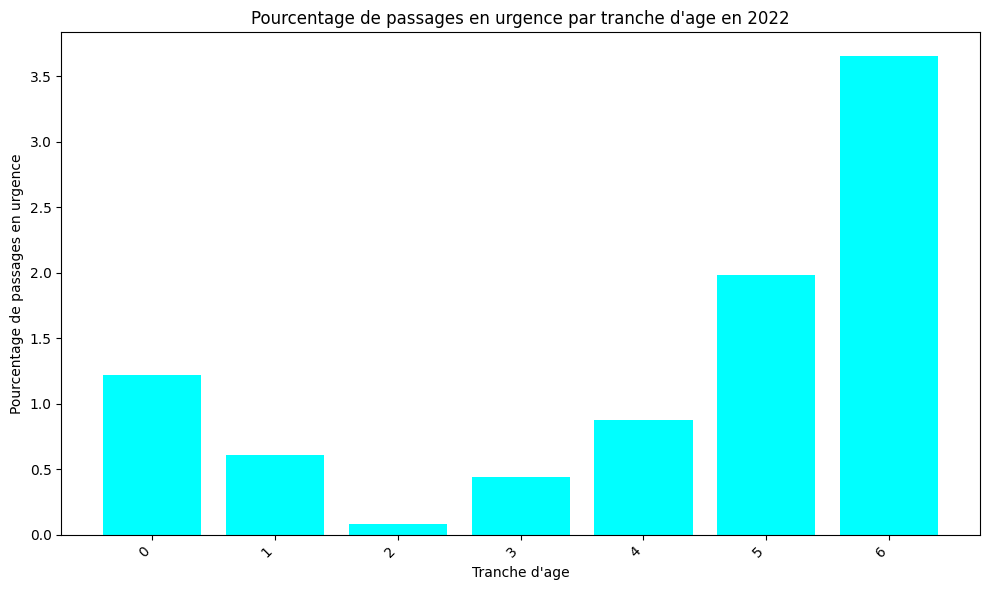

In [59]:
import psycopg2
import numpy as np 
import psycopg2.extras as extras 
import pandas as pd 
import matplotlib.pyplot as plt


"""Quel est le pourcentage de passages aux urgences pour suspicion de covid-19 par rapport au
nombre de passages total, par tranche d’âge en 2022 ?"""

def connexion():
    return psycopg2.connect(
   database="postgres",
   user="airflow",
   password="airflow",
   host="172.17.0.1",
   port= '5435')

def lecture(conn):
    """ Lecture des tables """
    command = """
        SELECT
            EXTRACT(YEAR FROM um.date_de_passage) AS annee,
            um.code_age,
            SUM(nbre_pass_tot) AS nombre_total_passages,
            SUM(nbre_pass_corona) AS nombre_passage_corona,
            (SUM(nbre_pass_corona)*100.0)/SUM(nbre_pass_tot) AS pourcentage
                    
        FROM
            urgence_mesures um
        JOIN
            departement d ON um.dep = d.id_dep
        WHERE EXTRACT(YEAR FROM um.date_de_passage) = 2022.0
        GROUP BY
            annee, um.code_age;
                """
    try:
        cur = conn.cursor()
        cur.execute(command)
        
        # Fetch data
        data = cur.fetchall()
        columns = [desc[0] for desc in cur.description]
        df = pd.DataFrame(data, columns=columns)
        
        # Display the DataFrame
        print(df)

    except (Exception, psycopg2.DatabaseError) as error:
        print("Error")
        print(error)
    finally:
        if cur is not None:
            cur.close()
        if conn is not None:
            conn.close()
        return df

# Call the function
connexion_instance = connexion()
df = lecture(connexion_instance)



# Créer un graphique à barres
donnee = df[['code_age', 'pourcentage']]
plt.figure(figsize=(10, 6))
plt.bar(donnee['code_age'], donnee['pourcentage'], color='cyan')
plt.xlabel("Tranche d'age")
plt.ylabel('Pourcentage de passages en urgence')
plt.title("Pourcentage de passages en urgence par tranche d'age en 2022")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

    annee  code_age  nombre_total_passages  nombre_passage_corona  \
0  2023.0         5                1231013                   9970   
1  2023.0         6                2103928                  30243   

              pourcentage  
0  0.80990208876754347842  
1      1.4374541334114095  


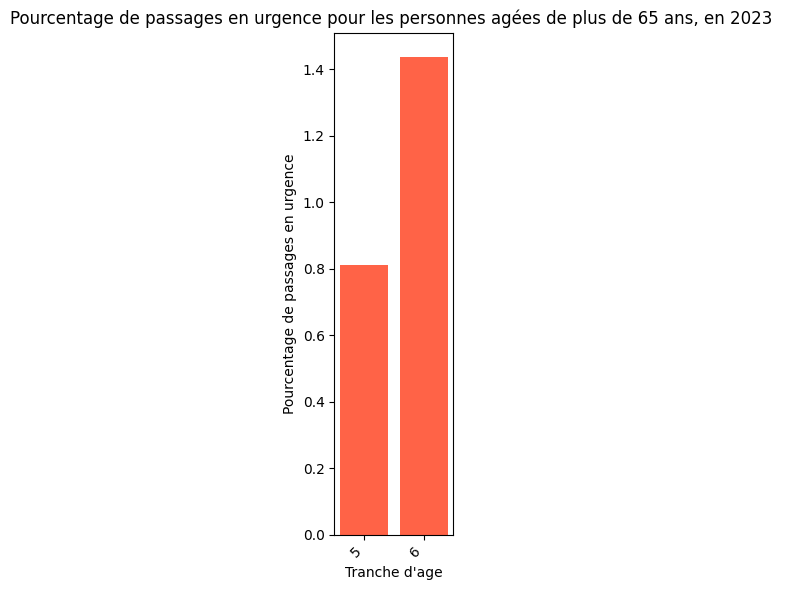

In [58]:
import psycopg2
import numpy as np 
import psycopg2.extras as extras 
import pandas as pd 
import matplotlib.pyplot as plt


"""Quel est le pourcentage de passages aux urgences pour suspicion de covid-19 par rapport au
nombre de passages total, pour les personnes agées de plus de 65 ans, en 2023 ?"""

def connexion():
    return psycopg2.connect(
   database="postgres",
   user="airflow",
   password="airflow",
   host="172.17.0.1",
   port= '5435')

def lecture(conn):
    """ Lecture des tables """
    command = """
        SELECT
            EXTRACT(YEAR FROM um.date_de_passage) AS annee,
            um.code_age,
            SUM(nbre_pass_tot) AS nombre_total_passages,
            SUM(nbre_pass_corona) AS nombre_passage_corona,
            (SUM(nbre_pass_corona)*100.0)/SUM(nbre_pass_tot) AS pourcentage
                    
        FROM
            urgence_mesures um
        JOIN
            departement d ON um.dep = d.id_dep
        WHERE EXTRACT(YEAR FROM um.date_de_passage) = 2023.0 and um.code_age>=5
        GROUP BY
            annee, um.code_age;
                """
    try:
        cur = conn.cursor()
        cur.execute(command)
        
        # Fetch data
        data = cur.fetchall()
        columns = [desc[0] for desc in cur.description]
        df = pd.DataFrame(data, columns=columns)
        
        # Display the DataFrame
        print(df)

    except (Exception, psycopg2.DatabaseError) as error:
        print("Error")
        print(error)
    finally:
        if cur is not None:
            cur.close()
        if conn is not None:
            conn.close()
        return df

# Call the function
connexion_instance = connexion()
df = lecture(connexion_instance)


# Créer un graphique à barres
donnee = df[['code_age', 'pourcentage']]
plt.figure(figsize=(2, 6))
plt.bar(donnee['code_age'], donnee['pourcentage'], color='tomato')
plt.xlabel("Tranche d'age")
plt.ylabel('Pourcentage de passages en urgence')
plt.title("Pourcentage de passages en urgence pour les personnes agées de plus de 65 ans, en 2023 ")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

      annee                  nom_dep  nombre_total_passages_f  \
0    2022.0                      Ain                     1176   
1    2022.0                    Aisne                     1813   
2    2022.0                   Allier                      857   
3    2022.0  Alpes-de-Haute-Provence                      641   
4    2022.0          Alpes-Maritimes                     2926   
..      ...                      ...                      ...   
196  2023.0                   Vendée                    58211   
197  2023.0                   Vienne                    40081   
198  2023.0                   Vosges                    41037   
199  2023.0                    Yonne                    56103   
200  2023.0                 Yvelines                   113752   

     nombre_passage_corona_f             pourcentage  
0                         14      1.1904761904761905  
1                         30      1.6547159404302261  
2                         16      1.8669778296382730  

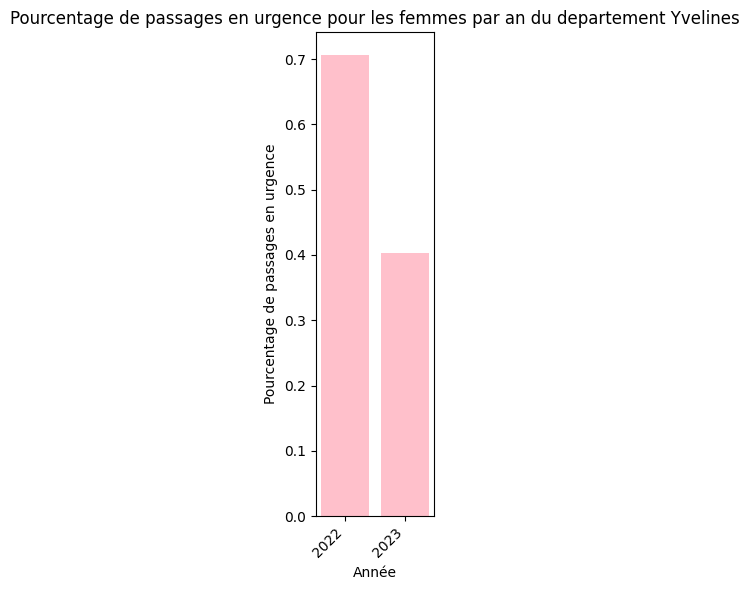

In [47]:
import psycopg2
import numpy as np 
import psycopg2.extras as extras 
import pandas as pd 
import matplotlib.pyplot as plt


"""Quel est le pourcentage de passages aux urgences pour suspicion de covid-19 par rapport au
nombre de passages total pour les femmes par an et par département ?"""

def connexion():
    return psycopg2.connect(
   database="postgres",
   user="airflow",
   password="airflow",
   host="172.17.0.1",
   port= '5435')

def lecture(conn):
    """ Lecture des tables """
    command = """
        SELECT
            EXTRACT(YEAR FROM um.date_de_passage) AS annee,
            d.nom_dep,
            SUM(nbre_pass_tot_f) AS nombre_total_passages_f,
            SUM(nbre_pass_corona_f) AS nombre_passage_corona_f,
            (SUM(nbre_pass_corona_f)*100.0)/SUM(nbre_pass_tot_f) AS pourcentage
                    
        FROM
            urgence_hospit uh
        JOIN
            urgence_mesures um ON um.id = uh.urgence_mesures_id
        JOIN
            departement d ON um.dep = d.id_dep
        
        GROUP BY
            annee, d.nom_dep;
                """
    try:
        cur = conn.cursor()
        cur.execute(command)
        
        # Fetch data
        data = cur.fetchall()
        columns = [desc[0] for desc in cur.description]
        df = pd.DataFrame(data, columns=columns)
        
        # Display the DataFrame
        print(df)

    except (Exception, psycopg2.DatabaseError) as error:
        print("Error")
        print(error)
    finally:
        if cur is not None:
            cur.close()
        if conn is not None:
            conn.close()
        return df

# Call the function
connexion_instance = connexion()
df = lecture(connexion_instance)



# Créer un graphique à barres
donnee = df[df['nom_dep'] == "Yvelines"]

plt.figure(figsize=(2, 6))
plt.bar(donnee['annee'], donnee['pourcentage'], color='pink')
plt.xlabel("Année")
plt.ylabel('Pourcentage de passages en urgence')
plt.title("Pourcentage de passages en urgence pour les femmes par an du departement Yvelines")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

      annee                  nom_dep  nombre_total_passages_h  \
0    2022.0                      Ain                     1196   
1    2022.0                    Aisne                     1830   
2    2022.0                   Allier                      912   
3    2022.0  Alpes-de-Haute-Provence                      607   
4    2022.0          Alpes-Maritimes                     2997   
..      ...                      ...                      ...   
196  2023.0                   Vendée                    66621   
197  2023.0                   Vienne                    44316   
198  2023.0                   Vosges                    44752   
199  2023.0                    Yonne                    59889   
200  2023.0                 Yvelines                   120382   

     nombre_passage_corona_h             pourcentage  
0                         15      1.2541806020066890  
1                         31      1.6939890710382514  
2                         18      1.9736842105263158  

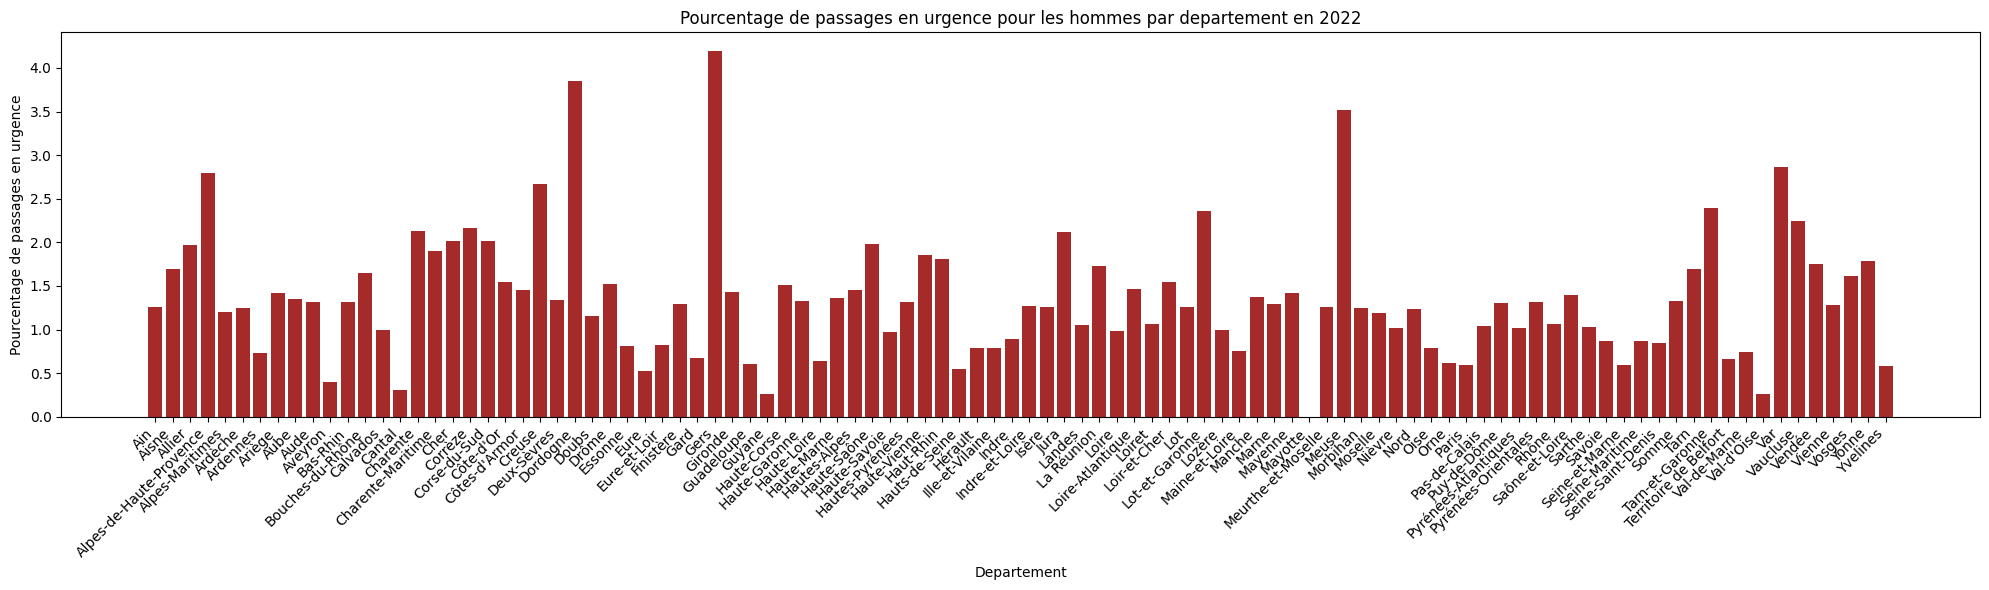

In [45]:
import psycopg2
import numpy as np 
import psycopg2.extras as extras 
import pandas as pd 
import matplotlib.pyplot as plt



"""Quel est le pourcentage de passages aux urgences pour suspicion de covid-19 par rapport au
nombre de passages total pour les hommes par an et par département ?"""

def connexion():
    return psycopg2.connect(
   database="postgres",
   user="airflow",
   password="airflow",
   host="172.17.0.1",
   port= '5435')

def lecture(conn):
    """ Lecture des tables """
    command = """
        SELECT
            EXTRACT(YEAR FROM um.date_de_passage) AS annee,
            d.nom_dep,
            SUM(nbre_pass_tot_h) AS nombre_total_passages_h,
            SUM(nbre_pass_corona_h) AS nombre_passage_corona_h,
            (SUM(nbre_pass_corona_h)*100.0)/SUM(nbre_pass_tot_h) AS pourcentage
                    
        FROM
            urgence_hospit uh
        JOIN
            urgence_mesures um ON um.id = uh.urgence_mesures_id
        JOIN
            departement d ON um.dep = d.id_dep
        
        GROUP BY
            annee, d.nom_dep;
                """
    try:
        cur = conn.cursor()
        cur.execute(command)
        
        # Fetch data
        data = cur.fetchall()
        columns = [desc[0] for desc in cur.description]
        df = pd.DataFrame(data, columns=columns)
        
        # Display the DataFrame
        print(df)

    except (Exception, psycopg2.DatabaseError) as error:
        print("Error")
        print(error)
    finally:
        if cur is not None:
            cur.close()
        if conn is not None:
            conn.close()
        return df

# Call the function
connexion_instance = connexion()
df = lecture(connexion_instance)


# Créer un graphique à barres
donnee = df[df['annee'] == 2022.0]

plt.figure(figsize=(20, 6))
plt.bar(donnee['nom_dep'], donnee['pourcentage'], color='brown')
plt.xlabel("Departement")
plt.ylabel('Pourcentage de passages en urgence')
plt.title("Pourcentage de passages en urgence pour les hommes par departement en 2022")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [76]:
pip install seaborn


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 5.6 MB/s eta 0:00:00 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


      mois        jour                   region  hospitalisations_hommes  \
0      6.0  2023-06-16            Île-de-France                        2   
1      5.0  2023-05-19            Île-de-France                        4   
2      5.0  2023-05-08                 Bretagne                        3   
3      8.0  2023-08-10  Bourgogne-Franche-Comté                        0   
4      1.0  2023-01-25                   Guyane                        0   
...    ...         ...                      ...                      ...   
5283   8.0  2023-08-25               Martinique                        1   
5284   7.0  2023-07-02               Guadeloupe                        1   
5285   8.0  2023-08-12                  Mayotte                        0   
5286  12.0  2022-12-29                  Mayotte                        0   
5287   8.0  2023-08-20                Occitanie                        8   

      hospitalisations_femmes  rapport_hommes_femmes  
0                           5   

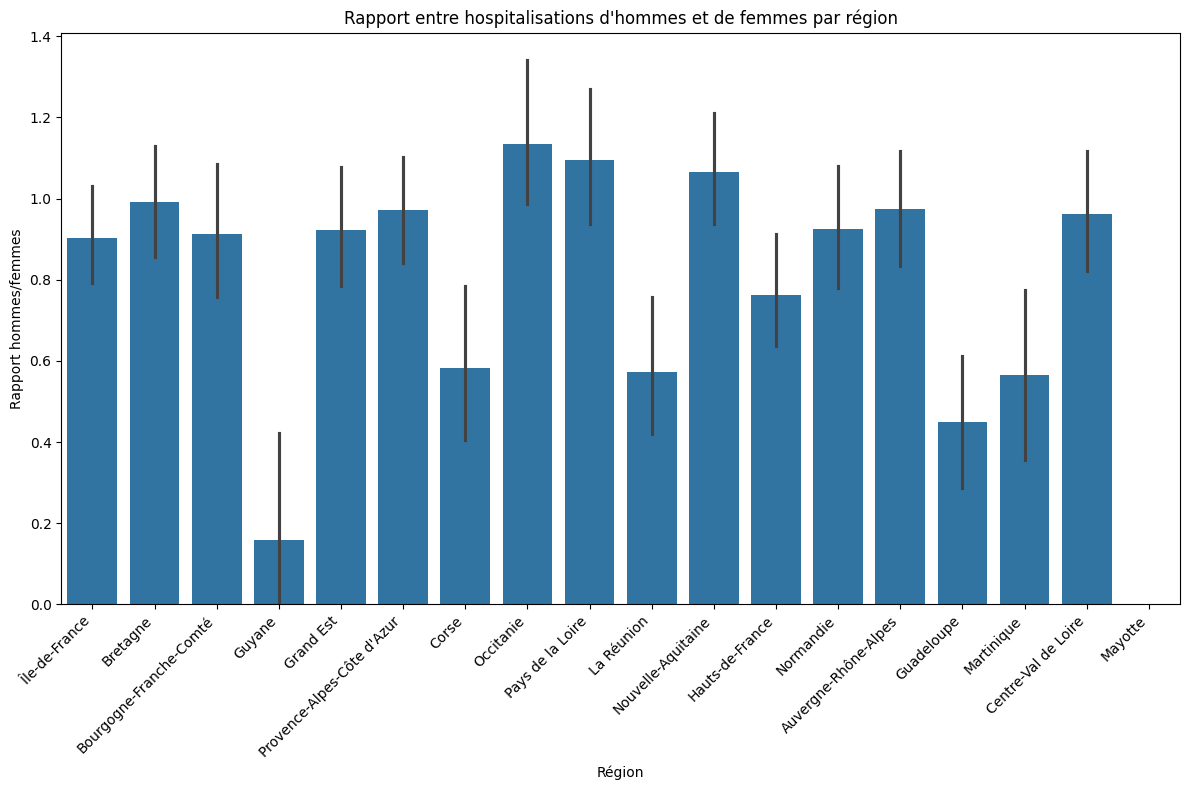

In [78]:
import psycopg2
import numpy as np 
import psycopg2.extras as extras 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

def connexion():
    return psycopg2.connect(
   database="postgres",
   user="airflow",
   password="airflow",
   host="172.17.0.1",
   port= '5435')

def lecture(conn):
    """ Lecture des tables """
    command = """
       SELECT
            EXTRACT(MONTH FROM um.date_de_passage) AS mois,
            um.date_de_passage AS jour,
            d.region,
            SUM(uh.nbre_hospit_corona_h) AS hospitalisations_hommes,
            SUM(uh.nbre_hospit_corona_f) AS hospitalisations_femmes,
            SUM(uh.nbre_hospit_corona_h) / NULLIF(SUM(uh.nbre_hospit_corona_f), 0) AS rapport_hommes_femmes
        FROM
            urgence_mesures um
        JOIN
            departement d ON um.dep = d.id_dep
        JOIN
            urgence_hospit uh ON um.id = uh.urgence_mesures_id
        GROUP BY
            mois,jour, d.region;

                """
    try:
        cur = conn.cursor()
        cur.execute(command)
        
        # Fetch data
        data = cur.fetchall()
        columns = [desc[0] for desc in cur.description]
        df = pd.DataFrame(data, columns=columns)
        
        # Display the DataFrame
        print(df)

    except (Exception, psycopg2.DatabaseError) as error:
        print("Error")
        print(error)
    finally:
        if cur is not None:
            cur.close()
        if conn is not None:
            conn.close()
        return df

# Call the function
connexion_instance = connexion()
df = lecture(connexion_instance)

df_filtered = df.dropna(subset=['rapport_hommes_femmes'])

# Créer un graphique en barres
plt.figure(figsize=(12, 8))
sns.barplot(x='region', y='rapport_hommes_femmes', data=df_filtered)

# Ajouter des étiquettes
plt.title('Rapport entre hospitalisations d\'hommes et de femmes par région')
plt.xlabel('Région')
plt.ylabel('Rapport hommes/femmes')
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes d'axe X pour une meilleure lisibilité

# Afficher le graphique
plt.tight_layout()
plt.show()
